In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    print("GPU memory cleared")

clear_gpu_memory()

Using device: cuda
GPU Name: Tesla T4
GPU memory cleared


In [2]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Increased to 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load content and style images with error handling
# Update paths for Kaggle (e.g., upload files to /kaggle/input/)
try:
    content_image = Image.open('/kaggle/input/data123/content_img2.jpeg').convert('RGB')
    style_image = Image.open('/kaggle/input/data123/starry_night.jpg').convert('RGB')
except FileNotFoundError as e:
    raise FileNotFoundError(f"Image not found: {e}. Upload images to /kaggle/input/")

# Preprocess images
content_tensor = transform(content_image).unsqueeze(0).to(device)
style_tensor = transform(style_image).unsqueeze(0).to(device)

# Verify shapes
print(f"Content Tensor Shape: {content_tensor.shape}")  # Should be [1, 3, 512, 512]
print(f"Style Tensor Shape: {style_tensor.shape}")    # Should be [1, 3, 512, 512]

Content Tensor Shape: torch.Size([1, 3, 512, 512])
Style Tensor Shape: torch.Size([1, 3, 512, 512])


In [3]:
# Load pretrained VGG-19
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Layers for content and style
content_layers = ['conv_4_2']  # Layer 21 in VGG-19
style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']  # Layers 0, 5, 10, 19, 28

# Mapping layer names to indices
layer_names = {
    '0': 'conv_1_1', '5': 'conv_2_1', '10': 'conv_3_1', 
    '19': 'conv_4_1', '21': 'conv_4_2', '28': 'conv_5_1'
}

# Feature extractor
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        self.vgg = vgg
        self.content_layers = content_layers
        self.style_layers = style_layers
    
    def forward(self, x):
        content_features = []
        style_features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            name = layer_names.get(str(i))
            if name in self.content_layers:
                content_features.append(x)
            if name in self.style_layers:
                style_features.append(x)
        return content_features, style_features

feature_extractor = VGGFeatureExtractor().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 235MB/s]


In [4]:
def content_loss(target, content):
    return nn.MSELoss()(target, content)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b * c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram.div(b * c * h * w)

def style_loss(target, style):
    loss = 0
    for t, s in zip(target, style):
        t_gram = gram_matrix(t)
        s_gram = gram_matrix(s)
        layer_loss = nn.MSELoss()(t_gram, s_gram)
        loss += layer_loss
    return loss

def total_variation_loss(image):
    return torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
           torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))

In [5]:
class StyleTransferModel(nn.Module):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Deeper layer
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  # Deeper layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )
        for module in self.model:
            if isinstance(module, nn.Conv2d):
                nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return torch.tanh(self.model(x))  # Tanh for [-1, 1] range

# Initialize model
model = StyleTransferModel().to(device)
optimizer = optim.LBFGS(model.parameters(), lr=1.0)

In [6]:
# Hyperparameters
num_epochs = 1000  # Increased to 3000
content_weight = 5.0
style_weight = 5e6
tv_weight = 1e-5
min_loss_improvement = 1e-4
patience = 100

# Lists to save losses
content_losses = []
style_losses = []
tv_losses = []
total_losses = []

# Precompute style and content features
model.eval()
with torch.no_grad():
    _, style_feats = feature_extractor(style_tensor)
    content_feats, _ = feature_extractor(content_tensor)

# Training with LBFGS
model.train()
best_loss = float('inf')
no_improvement_count = 0

def closure():
    optimizer.zero_grad()
    stylized_image = model(content_tensor)
    stylized_content_feats, stylized_style_feats = feature_extractor(stylized_image)
    
    # Compute losses
    c_loss = content_loss(stylized_content_feats[0], content_feats[0])
    s_loss = style_loss(stylized_style_feats, style_feats)
    tv_loss = total_variation_loss(stylized_image)
    
    # Total loss with explicit weighting
    weighted_s_loss = style_weight * s_loss
    loss = content_weight * c_loss + weighted_s_loss + tv_weight * tv_loss
    
    loss.backward()
    return loss

for epoch in range(num_epochs):
    optimizer.step(closure)
    
    # Recalculate losses for logging
    with torch.no_grad():
        stylized_image = model(content_tensor)
        stylized_content_feats, stylized_style_feats = feature_extractor(stylized_image)
        c_loss = content_loss(stylized_content_feats[0], content_feats[0])
        s_loss = style_loss(stylized_style_feats, style_feats)
        tv_loss = total_variation_loss(stylized_image)
        weighted_s_loss = style_weight * s_loss
        loss = content_weight * c_loss + weighted_s_loss + tv_weight * tv_loss
    
    # Save losses
    content_losses.append(c_loss.item())
    style_losses.append(s_loss.item())
    tv_losses.append(tv_loss.item())
    total_losses.append(loss.item())
    
    # Convergence check
    if loss.item() < best_loss - min_loss_improvement:
        best_loss = loss.item()
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    # Print progress every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Content Loss: {c_loss.item():.4f} | Style Loss: {weighted_s_loss.item():.6f} | "
              f"TV Loss: {tv_loss.item():.4f} | Total Loss: {loss.item():.4f}")
    
    # Early stopping
    if no_improvement_count >= patience:
        print(f"Early stopping at epoch {epoch+1}: Loss improvement < {min_loss_improvement} for {patience} epochs")
        break

# Save the model
torch.save(model.state_dict(), '/kaggle/working/starry_night_style_model.pth')

# Save the final stylized image with color enhancement
with torch.no_grad():
    final_stylized = model(content_tensor)
    final_stylized = final_stylized.squeeze(0).cpu()
    # Denormalize (adjusted for Tanh [-1, 1] range)
    final_stylized = (final_stylized + 1) / 2
    final_stylized = final_stylized * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    final_stylized = final_stylized.clamp(0, 1)
    output_image = transforms.ToPILImage()(final_stylized)
    output_image = ImageEnhance.Color(output_image).enhance(1.5)
    output_image.save('/kaggle/working/stylized_starry_night_output2.jpg')

# Clear GPU memory after training
clear_gpu_memory()

Epoch [1/1000] | Content Loss: 6.3919 | Style Loss: 235.099182 | TV Loss: 267944.5625 | Total Loss: 269.7380
Epoch [2/1000] | Content Loss: 6.5348 | Style Loss: 67.051239 | TV Loss: 352894.1875 | Total Loss: 103.2540
Epoch [3/1000] | Content Loss: 6.3693 | Style Loss: 40.631111 | TV Loss: 361869.5000 | Total Loss: 76.0963
Epoch [4/1000] | Content Loss: 6.1027 | Style Loss: 29.425787 | TV Loss: 362814.7812 | Total Loss: 63.5676
Epoch [5/1000] | Content Loss: 5.8076 | Style Loss: 23.436476 | TV Loss: 361823.8750 | Total Loss: 56.0928
Epoch [6/1000] | Content Loss: 5.5103 | Style Loss: 20.043421 | TV Loss: 361400.2500 | Total Loss: 51.2091
Epoch [7/1000] | Content Loss: 5.3173 | Style Loss: 18.194735 | TV Loss: 359695.3750 | Total Loss: 48.3784
Epoch [8/1000] | Content Loss: 5.1651 | Style Loss: 16.876339 | TV Loss: 358952.4375 | Total Loss: 46.2912
Epoch [9/1000] | Content Loss: 5.0309 | Style Loss: 15.847936 | TV Loss: 358458.1875 | Total Loss: 44.5869
Epoch [10/1000] | Content Loss: 4.

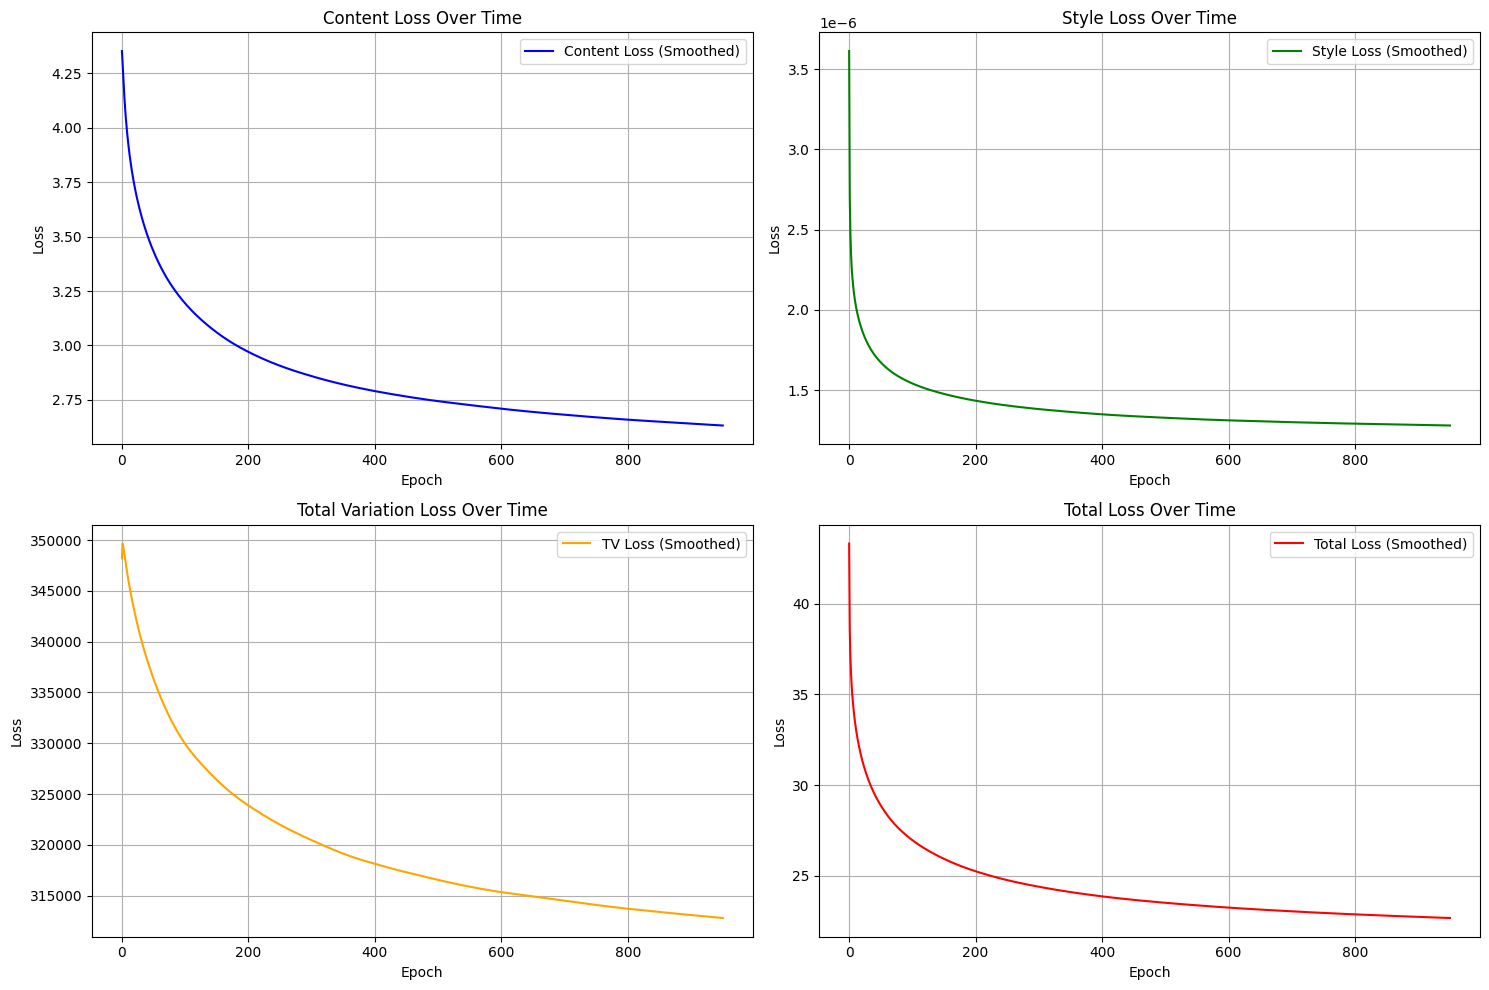

In [7]:
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(moving_average(content_losses, window_size), label='Content Loss (Smoothed)', color='blue')
plt.title('Content Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(moving_average(style_losses, window_size), label='Style Loss (Smoothed)', color='green')
plt.title('Style Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(moving_average(tv_losses, window_size), label='TV Loss (Smoothed)', color='orange')
plt.title('Total Variation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(moving_average(total_losses, window_size), label='Total Loss (Smoothed)', color='red')
plt.title('Total Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()